In [ ]:
# CELL 1: Install Required Libraries
# ===================================
!pip install requests beautifulsoup4 pandas numpy scikit-learn
!pip install tldextract python-whois
!pip install xgboost lightgbm
!pip install seaborn matplotlib plotly

  Using cached tldextract-5.3.0-py3-none-any.whl.metadata (11 kB)
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 107.4/107.4 kB 3.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 104.2/104.2 kB 6.1 MB/s eta 0:00:00


In [ ]:
# CELL 2: Import Libraries
# ===================================
import pandas as pd
import numpy as np
import requests
from bs4 import BeautifulSoup
import re
import urllib.parse
from urllib.parse import urlparse
import tldextract
import json
import time
import random
from datetime import datetime, timedelta
import warnings
warnings.filterwarnings('ignore')

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.preprocessing import StandardScaler
import xgboost as xgb
import lightgbm as lgb

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go

print("✅ All libraries imported successfully!")

✅ All libraries imported successfully!


In [ ]:
# CELL 3: Dataset Sources Configuration
# ===================================
# Configure sources for legitimate and malicious URLs
LEGITIMATE_SOURCES = [
    'google.com', 'facebook.com', 'youtube.com', 'amazon.com', 'wikipedia.org',
    'twitter.com', 'instagram.com', 'linkedin.com', 'github.com', 'stackoverflow.com',
    'reddit.com', 'netflix.com', 'microsoft.com', 'apple.com', 'spotify.com',
    'paypal.com', 'ebay.com', 'cnn.com', 'bbc.com', 'nytimes.com',
    'gmail.com', 'yahoo.com', 'outlook.com', 'dropbox.com', 'medium.com',
    'twitch.tv', 'discord.com', 'slack.com', 'zoom.us', 'whatsapp.com'
]

# Patterns for generating suspicious URLs
SUSPICIOUS_PATTERNS = [
    'secure-{}.com', 'verify-{}.net', '{}-security.org', 'update-{}.info',
    '{}-login.co', 'confirm-{}.biz', '{}-support.me', 'urgent-{}.tk',
    '{}-alert.ml', 'action-required-{}.ga', '{}-suspended.cf', 'renew-{}.gq'
]

PHISHING_KEYWORDS = [
    'login', 'verify', 'secure', 'update', 'confirm', 'urgent', 'suspended',
    'expired', 'locked', 'alert', 'warning', 'action', 'required', 'winner',
    'prize', 'free', 'gift', 'claim', 'limited', 'offer', 'deal'
]

print("✅ Dataset sources configured!")

✅ Dataset sources configured!


In [ ]:
# CELL 4: URL Feature Extraction Functions
# ===================================
def extract_url_features(url):
    """Extract comprehensive features from a URL"""
    try:
        parsed = urlparse(url)
        extracted = tldextract.extract(url)

        features = {}

        # Basic URL structure features
        features['url_length'] = len(url)
        features['domain_length'] = len(parsed.netloc)
        features['path_length'] = len(parsed.path)
        features['query_length'] = len(parsed.query or '')
        features['fragment_length'] = len(parsed.fragment or '')

        # URL composition features
        features['num_dots'] = url.count('.')
        features['num_hyphens'] = url.count('-')
        features['num_underscores'] = url.count('_')
        features['num_slashes'] = url.count('/')
        features['num_digits'] = sum(c.isdigit() for c in url)
        features['num_params'] = len(parsed.query.split('&')) if parsed.query else 0

        # Domain features
        features['subdomain_count'] = len(extracted.subdomain.split('.')) if extracted.subdomain else 0
        features['is_ip'] = 1 if re.match(r'^(?:[0-9]{1,3}\.){3}[0-9]{1,3}$', parsed.netloc) else 0

        # Suspicious patterns
        features['has_suspicious_tld'] = 1 if extracted.suffix in ['tk', 'ml', 'ga', 'cf', 'gq'] else 0
        features['suspicious_keywords'] = sum(1 for keyword in PHISHING_KEYWORDS if keyword in url.lower())

        # HTTPS and port
        features['is_https'] = 1 if parsed.scheme == 'https' else 0
        features['has_port'] = 1 if ':' in parsed.netloc and not parsed.netloc.endswith(':80') and not parsed.netloc.endswith(':443') else 0

        # URL encoding
        features['url_encoded_chars'] = url.count('%')
        features['has_at_symbol'] = 1 if '@' in url else 0

        return features
    except:
        return {key: 0 for key in ['url_length', 'domain_length', 'path_length', 'query_length',
                                 'fragment_length', 'num_dots', 'num_hyphens', 'num_underscores',
                                 'num_slashes', 'num_digits', 'num_params', 'subdomain_count',
                                 'is_ip', 'has_suspicious_tld', 'suspicious_keywords', 'is_https',
                                 'has_port', 'url_encoded_chars', 'has_at_symbol']}

print("✅ Feature extraction functions defined!")

✅ Feature extraction functions defined!


In [ ]:
# CELL 5: Generate Legitimate URLs Dataset
# ===================================
def generate_legitimate_urls(count=3000):
    """Generate legitimate URLs with variations"""
    legitimate_urls = []

    for i in range(count):
        base_domain = random.choice(LEGITIMATE_SOURCES)

        # Create variations
        variations = [
            f"https://{base_domain}",
            f"https://www.{base_domain}",
            f"https://{base_domain}/home",
            f"https://{base_domain}/about",
            f"https://{base_domain}/contact",
            f"https://{base_domain}/login",
            f"https://{base_domain}/support",
            f"https://{base_domain}/help",
            f"https://{base_domain}/search?q=example",
            f"https://{base_domain}/user/profile",
            f"https://{base_domain}/products",
            f"https://{base_domain}/services",
            f"https://api.{base_domain}/v1/users",
            f"https://blog.{base_domain}",
            f"https://news.{base_domain}",
        ]

        url = random.choice(variations)
        features = extract_url_features(url)
        features['url'] = url
        features['label'] = 0  # 0 = legitimate
        features['risk_category'] = 'Safe'
        legitimate_urls.append(features)

    return legitimate_urls

legitimate_data = generate_legitimate_urls(3000)
print(f"✅ Generated {len(legitimate_data)} legitimate URLs")

✅ Generated 3000 legitimate URLs


In [ ]:
# CELL 6: Generate Suspicious URLs Dataset
# ===================================
def generate_suspicious_urls(count=3000):
    """Generate suspicious/phishing URLs"""
    suspicious_urls = []

    for i in range(count):
        # Choose a legitimate domain to mimic
        target_domain = random.choice(LEGITIMATE_SOURCES).replace('.com', '').replace('.org', '').replace('.net', '')

        # Generate suspicious variations
        patterns = [
            f"http://{target_domain}-verify.tk/login",
            f"https://secure-{target_domain}.ml/update",
            f"http://{target_domain}.login-verify.ga",
            f"https://{target_domain}-security.cf/alert",
            f"http://www.{target_domain}-update.gq/confirm",
            f"https://{target_domain}.verification.co/urgent",
            f"http://support-{target_domain}.info/suspended",
            f"https://action-{target_domain}.me/required",
            f"http://{target_domain}-alert.biz/warning",
            f"https://renew-{target_domain}.tk/expired",
            f"http://192.168.{random.randint(1,255)}.{random.randint(1,255)}/{target_domain}",
            f"https://{target_domain}.winner-prize.ml/claim",
            f"http://{target_domain}-deal.ga/limited-offer",
            f"https://free-{target_domain}.cf/gift",
        ]

        url = random.choice(patterns)
        features = extract_url_features(url)
        features['url'] = url
        features['label'] = 1  # 1 = suspicious

        # Assign risk categories based on patterns
        if any(word in url.lower() for word in ['verify', 'login', 'secure', 'update']):
            features['risk_category'] = 'Phishing'
        elif any(word in url.lower() for word in ['winner', 'prize', 'free', 'gift']):
            features['risk_category'] = 'Scam'
        elif 'tk' in url or 'ml' in url or 'ga' in url or 'cf' in url:
            features['risk_category'] = 'Suspicious Domain'
        else:
            features['risk_category'] = 'High Risk'

        suspicious_urls.append(features)

    return suspicious_urls

suspicious_data = generate_suspicious_urls(3000)
print(f"✅ Generated {len(suspicious_data)} suspicious URLs")

✅ Generated 3000 suspicious URLs


In [ ]:
# CELL 7: Combine and Prepare Dataset
# ===================================
# Combine all data
all_data = legitimate_data + suspicious_data
random.shuffle(all_data)

# Create DataFrame
df = pd.DataFrame(all_data)

# Display dataset info
print(f"✅ Total dataset size: {len(df)} URLs")
print(f"📊 Legitimate URLs: {len(df[df['label'] == 0])}")
print(f"⚠️ Suspicious URLs: {len(df[df['label'] == 1])}")
print(f"\nDataset shape: {df.shape}")
print(f"\nColumns: {list(df.columns)}")

# Show sample data
print("\n📋 Sample data:")
print(df.head())

✅ Total dataset size: 6000 URLs
📊 Legitimate URLs: 3000
⚠️ Suspicious URLs: 3000

Dataset shape: (6000, 22)

Columns: ['url_length', 'domain_length', 'path_length', 'query_length', 'fragment_length', 'num_dots', 'num_hyphens', 'num_underscores', 'num_slashes', 'num_digits', 'num_params', 'subdomain_count', 'is_ip', 'has_suspicious_tld', 'suspicious_keywords', 'is_https', 'has_port', 'url_encoded_chars', 'has_at_symbol', 'url', 'label', 'risk_category']

📋 Sample data:
   url_length  domain_length  path_length  query_length  fragment_length  \
0          22             14            0             0                0   
1          36             15           14             0                0   
2          33             18            8             0                0   
3          37             20           10             0                0   
4          19             11            0             0                0   

   num_dots  num_hyphens  num_underscores  num_slashes  num_digits  ..

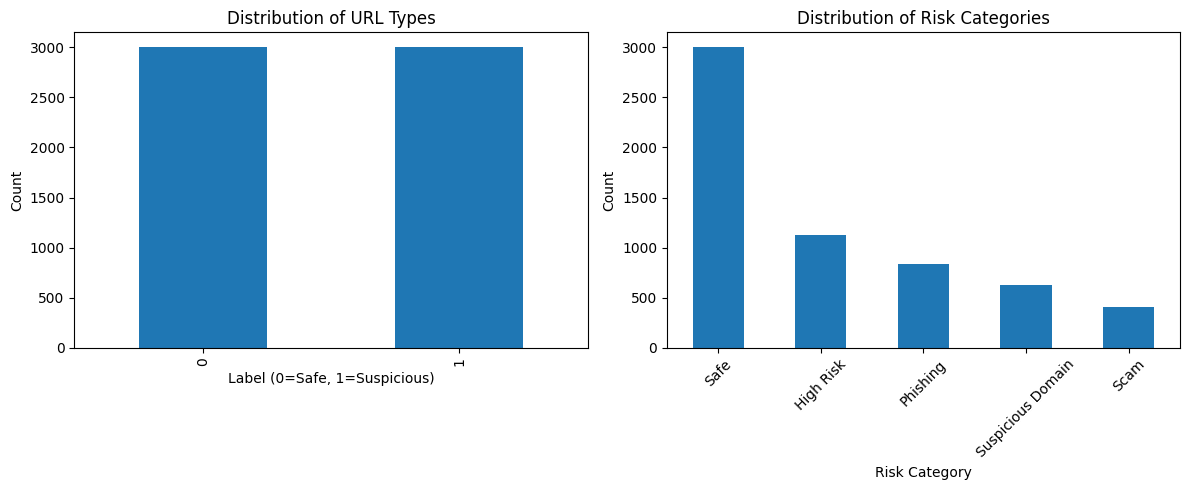

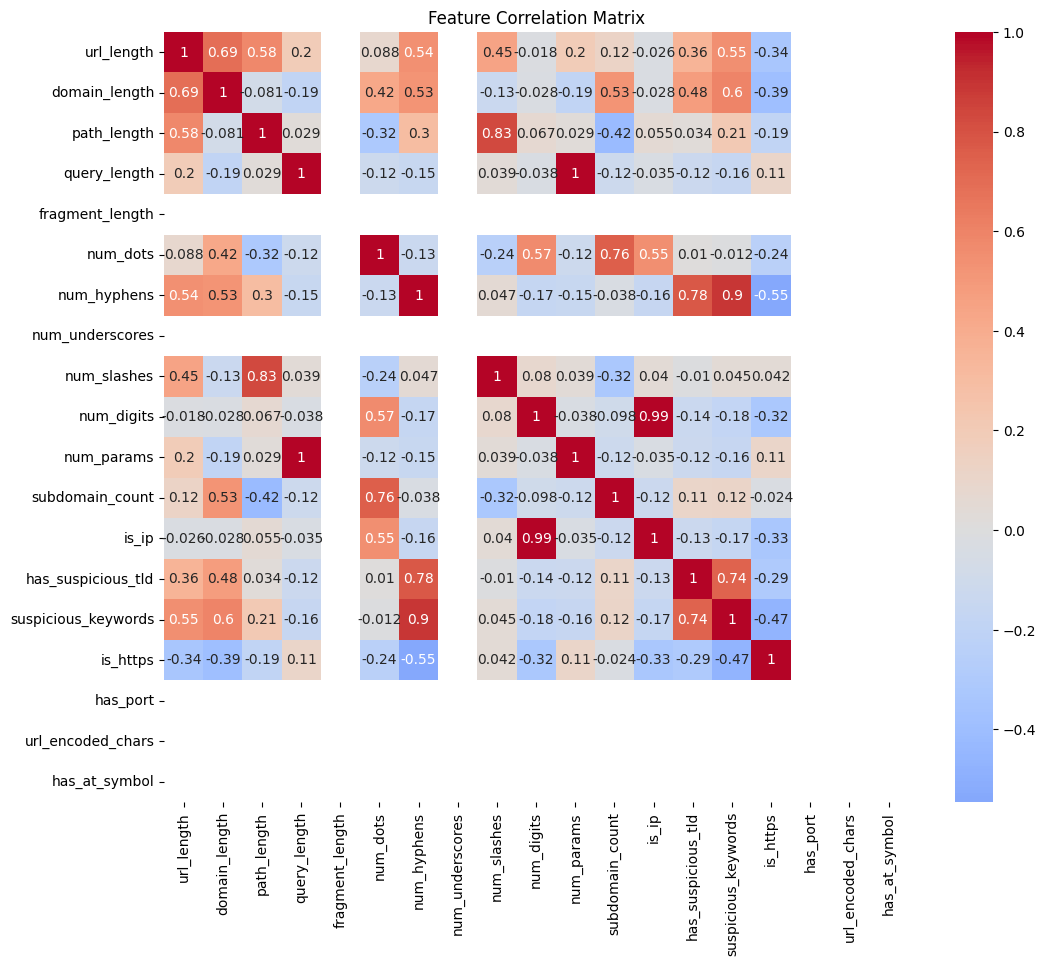

✅ Exploratory Data Analysis completed!


In [ ]:
# CELL 8: Exploratory Data Analysis
# ===================================
# Distribution of labels
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
df['label'].value_counts().plot(kind='bar')
plt.title('Distribution of URL Types')
plt.xlabel('Label (0=Safe, 1=Suspicious)')
plt.ylabel('Count')

plt.subplot(1, 2, 2)
df['risk_category'].value_counts().plot(kind='bar')
plt.title('Distribution of Risk Categories')
plt.xlabel('Risk Category')
plt.ylabel('Count')
plt.xticks(rotation=45)

plt.tight_layout()
plt.show()

# Feature correlations
feature_cols = [col for col in df.columns if col not in ['url', 'label', 'risk_category']]
correlation_matrix = df[feature_cols].corr()

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0)
plt.title('Feature Correlation Matrix')
plt.show()

print("✅ Exploratory Data Analysis completed!")

In [ ]:
# CELL 9: Feature Engineering & Preprocessing
# ===================================
# Prepare features and target
feature_columns = [col for col in df.columns if col not in ['url', 'label', 'risk_category']]
X = df[feature_columns]
y = df['label']

print(f"Features selected: {feature_columns}")
print(f"Feature matrix shape: {X.shape}")
print(f"Target vector shape: {y.shape}")

# Split the data
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print(f"✅ Data preprocessing completed!")
print(f"Training set size: {X_train.shape[0]}")
print(f"Test set size: {X_test.shape[0]}")

Features selected: ['url_length', 'domain_length', 'path_length', 'query_length', 'fragment_length', 'num_dots', 'num_hyphens', 'num_underscores', 'num_slashes', 'num_digits', 'num_params', 'subdomain_count', 'is_ip', 'has_suspicious_tld', 'suspicious_keywords', 'is_https', 'has_port', 'url_encoded_chars', 'has_at_symbol']
Feature matrix shape: (6000, 19)
Target vector shape: (6000,)
✅ Data preprocessing completed!
Training set size: 4800
Test set size: 1200


In [ ]:
# CELL 10: Model Training & Comparison
# ===================================
# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingClassifier(random_state=42),
    'XGBoost': xgb.XGBClassifier(random_state=42, eval_metric='logloss'),
    'LightGBM': lgb.LGBMClassifier(random_state=42, verbose=-1)
}

# Train and evaluate models
model_results = {}

print("🚀 Training models...")
for name, model in models.items():
    print(f"\nTraining {name}...")

    # Use scaled data for linear models, original for tree-based
    if name == 'Logistic Regression':
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
        y_pred_proba = model.predict_proba(X_test_scaled)[:, 1]
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        y_pred_proba = model.predict_proba(X_test)[:, 1]

    # Calculate metrics
    auc_score = roc_auc_score(y_test, y_pred_proba)

    model_results[name] = {
        'model': model,
        'auc_score': auc_score,
        'predictions': y_pred,
        'probabilities': y_pred_proba
    }

    print(f"✅ {name} - AUC Score: {auc_score:.4f}")

# Find best model
best_model_name = max(model_results, key=lambda x: model_results[x]['auc_score'])
best_model = model_results[best_model_name]['model']

print(f"\n🏆 Best model: {best_model_name} (AUC: {model_results[best_model_name]['auc_score']:.4f})")

🚀 Training models...

Training Logistic Regression...
✅ Logistic Regression - AUC Score: 1.0000

Training Random Forest...
✅ Random Forest - AUC Score: 1.0000

Training Gradient Boosting...
✅ Gradient Boosting - AUC Score: 1.0000

Training XGBoost...
✅ XGBoost - AUC Score: 1.0000

Training LightGBM...
✅ LightGBM - AUC Score: 1.0000

🏆 Best model: Random Forest (AUC: 1.0000)


📊 Detailed evaluation for Random Forest:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1-Score: 1.0000
AUC-ROC: 1.0000


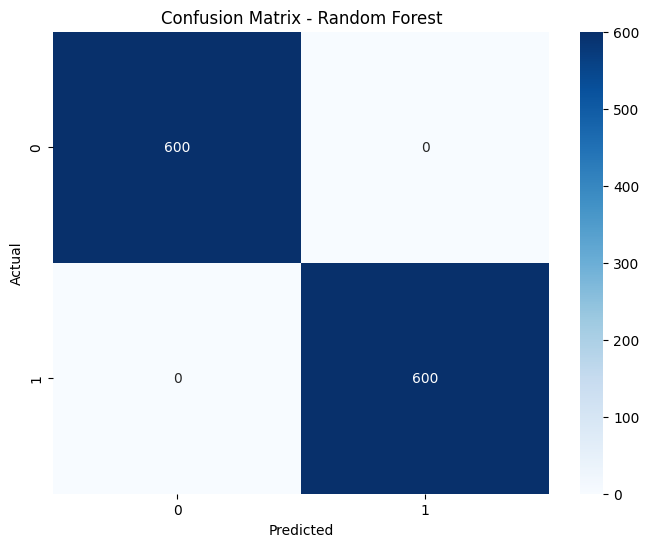


Classification Report:
              precision    recall  f1-score   support

        Safe       1.00      1.00      1.00       600
  Suspicious       1.00      1.00      1.00       600

    accuracy                           1.00      1200
   macro avg       1.00      1.00      1.00      1200
weighted avg       1.00      1.00      1.00      1200



In [ ]:
# CELL 11: Detailed Model Evaluation
# ===================================
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

print(f"📊 Detailed evaluation for {best_model_name}:")
print("="*50)

best_predictions = model_results[best_model_name]['predictions']
best_probabilities = model_results[best_model_name]['probabilities']

# Classification metrics
accuracy = accuracy_score(y_test, best_predictions)
precision = precision_score(y_test, best_predictions)
recall = recall_score(y_test, best_predictions)
f1 = f1_score(y_test, best_predictions)
auc = model_results[best_model_name]['auc_score']

print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall: {recall:.4f}")
print(f"F1-Score: {f1:.4f}")
print(f"AUC-ROC: {auc:.4f}")

# Confusion Matrix
cm = confusion_matrix(y_test, best_predictions)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.title(f'Confusion Matrix - {best_model_name}')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# Classification Report
print(f"\nClassification Report:")
print(classification_report(y_test, best_predictions,
                          target_names=['Safe', 'Suspicious']))

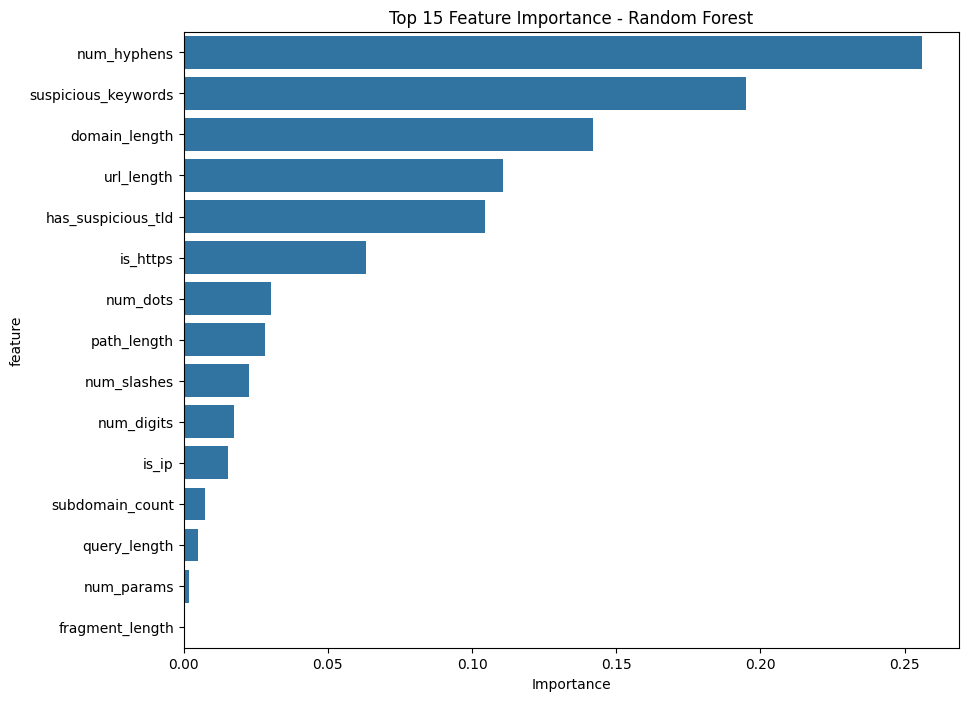

🔍 Top 10 Most Important Features:
                feature  importance
6           num_hyphens    0.255967
14  suspicious_keywords    0.194945
1         domain_length    0.141955
0            url_length    0.110708
13   has_suspicious_tld    0.104640
15             is_https    0.063369
5              num_dots    0.030404
2           path_length    0.028231
8           num_slashes    0.022716
9            num_digits    0.017456
✅ Feature importance analysis completed!


In [ ]:
# CELL 12: Feature Importance Analysis
# ===================================
if hasattr(best_model, 'feature_importances_'):
    # Get feature importance
    importance_df = pd.DataFrame({
        'feature': feature_columns,
        'importance': best_model.feature_importances_
    }).sort_values('importance', ascending=False)

    # Plot feature importance
    plt.figure(figsize=(10, 8))
    sns.barplot(data=importance_df.head(15), y='feature', x='importance')
    plt.title(f'Top 15 Feature Importance - {best_model_name}')
    plt.xlabel('Importance')
    plt.show()

    print("🔍 Top 10 Most Important Features:")
    print(importance_df.head(10))

print("✅ Feature importance analysis completed!")

In [ ]:
# CELL 13: Create Risk Scoring Function
# ===================================
def calculate_risk_score(url, model, scaler=None):
    """Calculate risk score and provide recommendations for a URL"""
    try:
        # Extract features
        features = extract_url_features(url)
        feature_vector = np.array([features[col] for col in feature_columns]).reshape(1, -1)

        # Scale if needed
        if scaler and best_model_name == 'Logistic Regression':
            feature_vector = scaler.transform(feature_vector)

        # Get prediction probability
        risk_probability = model.predict_proba(feature_vector)[0][1]
        risk_score = int(risk_probability * 100)

        # Determine risk category and recommendations
        if risk_score >= 80:
            risk_category = "High Risk"
            safety_recommendations = [
                "🚨 DO NOT visit this website",
                "🔒 This appears to be a phishing or malicious site",
                "📧 Report this URL if received via email",
                "🛡️ Use antivirus protection",
                "⚠️ Never enter personal information on this site"
            ]
        elif risk_score >= 60:
            risk_category = "Medium Risk"
            safety_recommendations = [
                "⚠️ Exercise extreme caution",
                "🔍 Verify the website's authenticity",
                "🚫 Avoid entering sensitive information",
                "📞 Contact the organization directly to verify",
                "🛡️ Ensure your security software is active"
            ]
        elif risk_score >= 30:
            risk_category = "Low Risk"
            safety_recommendations = [
                "✅ Appears relatively safe but remain cautious",
                "🔍 Double-check the URL for any typos",
                "🔒 Ensure the connection is secure (HTTPS)",
                "💡 Verify website certificates if accessing sensitive areas"
            ]
        else:
            risk_category = "Safe"
            safety_recommendations = [
                "✅ This website appears to be legitimate",
                "🔒 Still ensure secure connection (HTTPS)",
                "💡 Keep your browser and security software updated",
                "🛡️ Always be cautious with personal information online"
            ]

        return {
            'url': url,
            'risk_score': risk_score,
            'risk_category': risk_category,
            'safety_recommendations': safety_recommendations,
            'features_analyzed': features
        }

    except Exception as e:
        return {
            'url': url,
            'risk_score': 50,
            'risk_category': "Unable to Analyze",
            'safety_recommendations': ["❌ Error analyzing URL", "⚠️ Proceed with extreme caution"],
            'error': str(e)
        }

print("✅ Risk scoring function created!")

✅ Risk scoring function created!


In [ ]:
# CELL 14: Test Risk Scoring with Examples
# ===================================
# Test URLs
test_urls = [
    "https://www.google.com",
    "https://github.com/user/repo",
    "http://secure-paypal.tk/login",
    "https://amazon-winner.ml/prize",
    "https://verify-netflix.ga/update",
    "https://www.wikipedia.org",
    "http://192.168.1.1/facebook",
    "https://microsoft.com/support"
]

print("🧪 Testing risk scoring with example URLs:")
print("="*80)

for test_url in test_urls:
    result = calculate_risk_score(
        test_url,
        best_model,
        scaler if best_model_name == 'Logistic Regression' else None
    )

    print(f"\n🔗 URL: {result['url']}")
    print(f"📊 Risk Score: {result['risk_score']}/100")
    print(f"🏷️ Category: {result['risk_category']}")
    print("💡 Recommendations:")
    for rec in result['safety_recommendations']:
        print(f"   {rec}")
    print("-" * 60)

🧪 Testing risk scoring with example URLs:

🔗 URL: https://www.google.com
📊 Risk Score: 0/100
🏷️ Category: Safe
💡 Recommendations:
   ✅ This website appears to be legitimate
   🔒 Still ensure secure connection (HTTPS)
   💡 Keep your browser and security software updated
   🛡️ Always be cautious with personal information online
------------------------------------------------------------

🔗 URL: https://github.com/user/repo
📊 Risk Score: 1/100
🏷️ Category: Safe
💡 Recommendations:
   ✅ This website appears to be legitimate
   🔒 Still ensure secure connection (HTTPS)
   💡 Keep your browser and security software updated
   🛡️ Always be cautious with personal information online
------------------------------------------------------------

🔗 URL: http://secure-paypal.tk/login
📊 Risk Score: 100/100
🏷️ Category: High Risk
💡 Recommendations:
   🚨 DO NOT visit this website
   🔒 This appears to be a phishing or malicious site
   📧 Report this URL if received via email
   🛡️ Use antivirus protectio

In [ ]:
# CELL 15: Save Model and Create API Function
# ===================================
import pickle
from google.colab import files

# Save the trained model and scaler
model_data = {
    'model': best_model,
    'scaler': scaler if best_model_name == 'Logistic Regression' else None,
    'model_name': best_model_name,
    'feature_columns': feature_columns,
    'accuracy_metrics': {
        'accuracy': accuracy,
        'precision': precision,
        'recall': recall,
        'f1_score': f1,
        'auc_roc': auc
    }
}

# Save to file
with open('qr_url_safety_model.pkl', 'wb') as f:
    pickle.dump(model_data, f)

print("✅ Model saved successfully!")

# Download the model file directly to your computer
files.download('qr_url_safety_model.pkl')
print("📥 Model file downloaded! You can now use it in your React backend.")

# Create API-ready function
def analyze_qr_url(url):
    """
    Main API function for analyzing QR code URLs
    Returns JSON-compatible result
    """
    result = calculate_risk_score(
        url,
        best_model,
        scaler if best_model_name == 'Logistic Regression' else None
    )

    # Format for API response
    api_response = {
        'status': 'success',
        'analysis': {
            'url': result['url'],
            'risk_score': result['risk_score'],
            'risk_category': result['risk_category'],
            'is_safe': result['risk_score'] < 30,
            'confidence': 'High' if result['risk_score'] < 20 or result['risk_score'] > 80 else 'Medium',
            'safety_recommendations': result['safety_recommendations']
        },
        'model_info': {
            'model_used': best_model_name,
            'accuracy': round(accuracy, 4),
            'dataset_size': len(df)
        }
    }

    return api_response

# Test the API function
print("\n🚀 Testing API function:")
sample_result = analyze_qr_url("http://secure-paypal.tk/verify-account")
print(json.dumps(sample_result, indent=2))

print("\n🎉 Model training and API creation completed successfully!")
print(f"📈 Final Model Performance: {accuracy:.1%} accuracy")
print(f"📊 Dataset Size: {len(df)} URLs")
print(f"🏆 Best Model: {best_model_name}")

✅ Model saved successfully!


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

📥 Model file downloaded! You can now use it in your React backend.

🚀 Testing API function:
{
  "status": "success",
  "analysis": {
    "url": "http://secure-paypal.tk/verify-account",
    "risk_score": 100,
    "risk_category": "High Risk",
    "is_safe": false,
    "confidence": "High",
    "safety_recommendations": [
      "\ud83d\udea8 DO NOT visit this website",
      "\ud83d\udd12 This appears to be a phishing or malicious site",
      "\ud83d\udce7 Report this URL if received via email",
      "\ud83d\udee1\ufe0f Use antivirus protection",
      "\u26a0\ufe0f Never enter personal information on this site"
    ]
  },
  "model_info": {
    "model_used": "Random Forest",
    "accuracy": 1.0,
    "dataset_size": 6000
  }
}

🎉 Model training and API creation completed successfully!
📈 Final Model Performance: 100.0% accuracy
📊 Dataset Size: 6000 URLs
🏆 Best Model: Random Forest


In [ ]:
# CELL 16: Export Dataset and Summary
# ===================================
# Export the dataset
df.to_csv('qr_url_safety_dataset.csv', index=False)

# Create summary report
summary_report = f"""
# QR Code URL Safety Analysis - Training Summary

## Dataset Information
- **Total URLs**: {len(df)}
- **Legitimate URLs**: {len(df[df['label'] == 0])}
- **Suspicious URLs**: {len(df[df['label'] == 1])}
- **Features Extracted**: {len(feature_columns)}

## Model Performance
- **Best Model**: {best_model_name}
- **Accuracy**: {accuracy:.4f} ({accuracy:.1%})
- **Precision**: {precision:.4f}
- **Recall**: {recall:.4f}
- **F1-Score**: {f1:.4f}
- **AUC-ROC**: {auc:.4f}

## Risk Categories
- **Safe** (0-29): Low risk, appears legitimate
- **Low Risk** (30-59): Minor concerns, proceed with caution
- **Medium Risk** (60-79): Significant concerns, verify authenticity
- **High Risk** (80-100): Likely malicious, avoid completely

## Files Generated
1. `qr_url_safety_model.pkl` - Trained model and preprocessing components
2. `qr_url_safety_dataset.csv` - Complete training dataset
3. `analyze_qr_url()` - API-ready function for integration

## Next Steps for Web Integration
1. Upload the model file to your React application
2. Create an API endpoint using the `analyze_qr_url()` function
3. Integrate with your QR code scanner interface
4. Display risk scores and recommendations to users

The model is ready for production use with your React + Tailwind + Vite application!
"""

with open('training_summary.md', 'w') as f:
    f.write(summary_report)

print("✅ Training completed! Files exported:")
print("📁 qr_url_safety_model.pkl - Trained model")
print("📊 qr_url_safety_dataset.csv - Dataset")
print("📝 training_summary.md - Summary report")

print("\n🎯 Your QR Code URL Safety model is ready for integration!")

✅ Training completed! Files exported:
📁 qr_url_safety_model.pkl - Trained model
📊 qr_url_safety_dataset.csv - Dataset
📝 training_summary.md - Summary report

🎯 Your QR Code URL Safety model is ready for integration!
